# Identifikace systému, odhad parametrů modelu

Tento notebook je interaktivní, každou buňku můžete vykonat stisknutím `Shift-Enter`, můžete změnit její obsah a opětovně ji vykonat.

V kódu jsou tzv. elipsy, buď jako tři tečky `...` nebo podtržítko `_` v místě, kdě je potřeba doplnit nebo naprogramovat část dle zadání úkolu.

## Příprava v Modelice

- na fyzické mašině, naklonujte si `Physiolibrary-models` nejlépe do stejného adresáře jako je Bodylight-notebooks nebo Bodylight-VirtualMachine `git clone https://github.com/creative-connections/Physiolibrary-models`
- ve virtuální mašině v OMEdit (nebo Dymola) otevřete `/vagrant_data/Physiolibrary_models/Metabolism/package.mo`
- vytvořte GlucoseToleranceTest1, který v čase 50h od začátku simulace bude pumpovat glukózu rychlostí 100 g za hodinu po dobu 20 minut, přepočtěte na mg/s a spojte je s GIRegulationBlock, simulujte 3 dny, zobrazte koncetraci glukózy a inzulínu (out1 a out2)
- vytvořte GlucoseToleranceTest2, který v čase 50h od začátku simulace bude pumpovat glukózu rychlostí 100 g za hodinu po dobu 20 minut, přepočtěte na kg/s a spojte je s GIRegulationComponent, simulujte 3 dny
- zkuste měnit parametry beta a nu (na 10% původní hodnoty), simulujte 3 dny
- exportujte GlucoseToleranceTest2 od FMU (mód ME), soubor dejte do adresáře `Seminar8FmiIdentification/fmus/`
 


## 1 Problém

Budeme zpracovávat data měření tzv. glukózového tolerančního testu. Máme informace, že pacient dostával intravenózně glukózu do krve rychlostí 28 mg/s. po dobu 12 minut. Pak byly v 12 minutových intervalech prováděny testy koncentrace glukózy a inzulínu hodnoty jsou v souborech `data/PatientX_y.csv` kde `X` je označení pacienta a `y` je buď `g`lukóza nebo `i`nzulín.


In [1]:
# nacteme soubor s daty glukozy pro pacienta A 
import numpy
data = numpy.genfromtxt('data/PatientA_g.csv',delimiter=',')
data

array([1.497, 1.49 , 2.772, 2.647, 2.542, 2.425, 2.371, 2.294, 2.164,
       2.038])

In [2]:
# casovou osu vygenerujeme, dle zadani to jde po 12 minutach (tj. po 720 sekundach)
time = numpy.arange(0,720*data.size,720)
time

array([   0,  720, 1440, 2160, 2880, 3600, 4320, 5040, 5760, 6480])

In [3]:
# definujeme rutinu pro kresleni grafu
def plot(x,y,z=None,labely=None,labelz=None):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(x,y,label=labely,color='red')
    if z is not None:
        plt.plot(x,z, label=labelz,color='blue')
    plt.legend()
    plt.grid(True)
    plt.show()


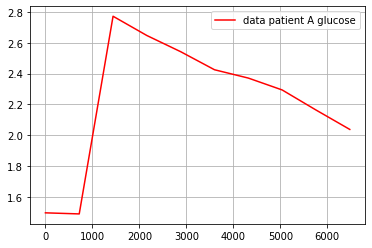

In [4]:
plot(time,data,labely="data patient A glucose")

## 2. FmPy nebo PyFMI knihovny a simulace modelu v Pythonu


Model z Modeliky exportovat jako FMU (nejlépe verze 2.0 v módu ModelExchange nebo Co-Simulation). V OpenModelice 1.16.x doporučujeme exportovat v módu ModelExchange. V Dymole doporučujeme exportovat v módu Co-Simulation (solver DASSL je robustní).

Knihovny FmPy a PyFMI zjednodušují simulace FMU v Pythonu. FmPy implementuje solvery v Pythonu. Knihovna PyFMI používá implementace z jiných knihoven v C++, které jsou obecně rychlejší.

V dalším textu budeme používat FmPy.

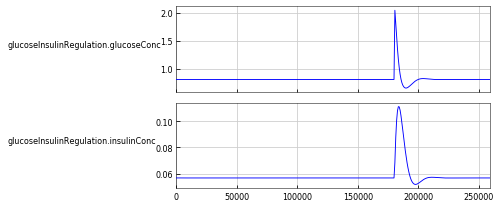

In [5]:
import fmpy
model1 = 'fmus/Metabolism.GlucoseInsulin.Test.GlucoseToleranceTest.fmu' 
result1 = result = fmpy.simulate_fmu(
    model1,
    start_time=0,
    stop_time=259200,
    step_size=720,
    record_events=False,
    output=['glucoseInsulinRegulation.glucoseConc','glucoseInsulinRegulation.insulinConc'],
    start_values={'glucoseInsulinRegulation.tissueUtilizationInsulinDependent.Nu_permu': 139000,'glucoseInsulinRegulation.insulinProduction.beta_mu': 1430},
    solver='CVode')
fmpy.util.plot_result(result1)

Jestli se objeví chyba, je třeba nainstalovat fmpy, např.: `conda install -c conda-forge fmpy`.

## 3. Kalibrace dat a simulace pro odhad parametrů


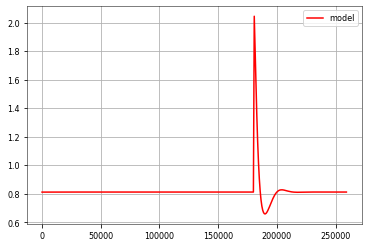

In [6]:
plot(result1['time'],result1['glucoseInsulinRegulation.glucoseConc'],labely='model')

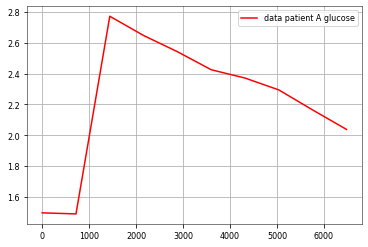

In [7]:
plot(time,data,labely="data patient A glucose")

3.1 data a simulace modelu jsou vzorkována stejně? 

Ano - interval 12 minut (720s)

3.2 Odpovídají vzorky simulace modelu odpovídají vzorkům dat podle simulovaného experimentu? 

In [8]:
print('data size',time.size,' model simulation size:',result1['time'].size)

data size 10  model simulation size: 361


Musíme vybrat začátek, kde simulace modelu začne odpovídat tomu co se děje v reálných datech

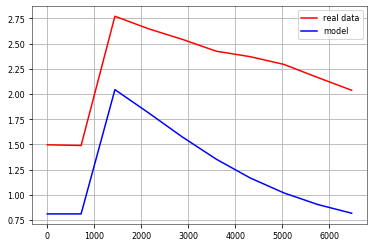

In [9]:
model = result1['glucoseInsulinRegulation.glucoseConc'][249:259]
plot(time,data,model,labely='real data',labelz='model')

In [10]:
cindex = 249 # calibrating index



In [11]:
# Porovnani modelu a simulace jako funkce
def simulatemodelbeta(relativebeta=1,modelfile=model1):
    # odsimulovat s parametrem beta*relativebeta
    modelresult = fmpy.simulate_fmu(
        modelfile,
        start_time=0,
        stop_time=259200,
        step_size=720,
        record_events=False,
        output=['glucoseInsulinRegulation.glucoseConc','glucoseInsulinRegulation.insulinConc'],
        start_values={
            'glucoseInsulinRegulation.tissueUtilizationInsulinDependent.Nu_permu': 139000,
            'glucoseInsulinRegulation.insulinProduction.beta_mu': 1430*relativebeta
        },
        solver='CVode')
    return modelresult;

def comparemodeldatabeta(relativebeta=1,realdata=data,realtime=time,modelfile=model1):
    modelresult = simulatemodelbeta(relativebeta,modelfile)
    # vykreslit do grafu
    plot(realtime,realdata,modelresult['glucoseInsulinRegulation.glucoseConc'][cindex:cindex+10],labely='real data',labelz='model')
    



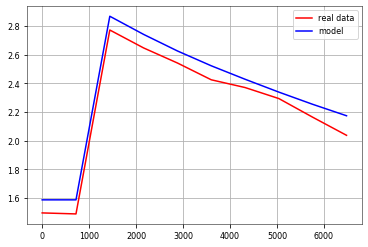

In [12]:
comparemodeldatabeta(0.1)

Zkusíme najit hrubou silou parametr `beta` tak, aby model odpovídal co nejvíc datům - rozdíl mezi modelem a daty byl minimální.

Nejprve definujeme metriku rozdílu mezi simulací modelu a daty, tj. účelová funkce (objective function) $ y=\sum_{i=1}^n (s_i - d_i)^2 $ kde $s_i$ je hodnota sledované veličiny simulace v bodu $i$ a $d_i$ je hodnota sledované veličiny naměřených dat.



In [13]:
def mydiff(s,d):
    sum = 0
    for i in range(0,s.size):
        sum+=(s[i]-d[i])**2
    return sum

Nyní definujeme cyklus, který odsimuluje model s parametry 1 promile až 1000 promile normální hodnoty beta.

In [14]:
# hrubou silou odsimulujeme vsech 1000 moznych hodnot
#diffs = [] # pole s hodnotou ucelove funkci a parametrem
#for i in range(1,1000):
#    modelresult = simulatemodelbeta(i/1000)
#    diff= mydiff(modelresult['glucoseInsulinRegulation.glucoseConc'][cindex:cindex+10],data)
#    diffs.append([i/1000,diff])
# v poli diffs mam nyni parametr a hodnotu ucelove funkce (vzdalenost mezi simulaci a realnymi daty)

In [15]:
# varianta, pokud predchozi vypocet spadl, hrubou silou zkusime procenta
diffs = [] # pole s hodnotou ucelove funkci a parametrem
for i in range(1,100):
    modelresult = simulatemodelbeta(i/100)
    diff= mydiff(modelresult['glucoseInsulinRegulation.glucoseConc'][cindex:cindex+10],data)
    diffs.append([i/100,diff])


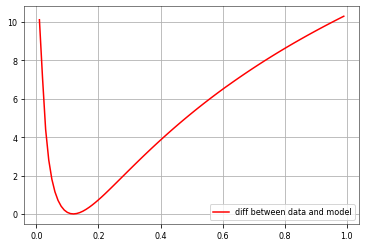

In [16]:
# muzeme zobrazit jak procento beta ovlivnuje rozdil mezi daty a modelem
ndiffs = numpy.array(diffs)
plot(ndiffs[:,0],ndiffs[:,1],labely="diff between data and model")

Hodnota parametru s nejnizsi hodnotou ucelove funkce je hledany odhad parametru, ktery odpovida realnym datum.

In [17]:
diffs.sort(key=lambda x:x[1])

Nejlepsi shoda modelu s daty je prvni (v Pythonu nulty prvek setrideneho pole).

In [18]:
modelbeta = diffs[0][0]
print('Nejlepsi shoda modelu s daty je pro parametr beta (v podilu k normalni hodnote)= ',modelbeta)

Nejlepsi shoda modelu s daty je pro parametr beta (v podilu k normalni hodnote)=  0.12


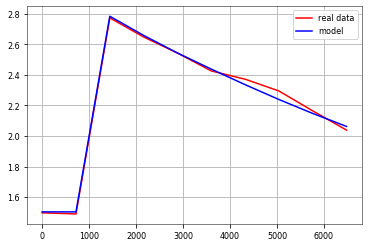

In [19]:
# jak vypada srovnani dat a modelu (hodnota parametru je v procentech - musime vydelit 100)
comparemodeldatabeta(diffs[0][0])

0.11


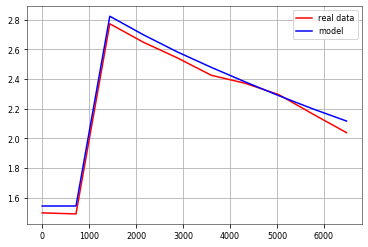

In [20]:
# jak vypada srovnani dat a modelu s 2 nejlepsi hodnotou parametru?
print(diffs[1][0])
comparemodeldatabeta(diffs[1][0])

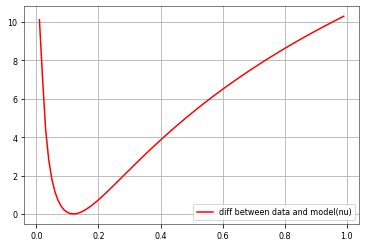

Nejlepsi shoda dat a modelu s parametrem nu v procentech s normou=  0.12


In [21]:
# Jak je to s parametrem ny (nu)
# Porovnani modelu a simulace jako funkce
def simulatemodelnu(relativenu=1,modelfile=model1):
    # odsimulovat s parametrem beta*relativebeta
    modelresult = fmpy.simulate_fmu(
        modelfile,
        start_time=0,
        stop_time=259200,
        step_size=720,
        record_events=False,
        output=['glucoseInsulinRegulation.glucoseConc','glucoseInsulinRegulation.insulinConc'],
        start_values={
            'glucoseInsulinRegulation.tissueUtilizationInsulinDependent.Nu_permu': 139000*relativenu,
            'glucoseInsulinRegulation.insulinProduction.beta_mu': 1430
        },
        solver='CVode')
    return modelresult;
def comparemodeldatanu(relativenu=1,realdata=data,realtime=time,modelfile=model1):
    modelresult = simulatemodelnu(relativenu,modelfile)
    # vykreslit do grafu
    plot(realtime,realdata,modelresult['glucoseInsulinRegulation.glucoseConc'][cindex:cindex+10],labely='real data',labelz='model')
diffs2 = [] # pole s hodnotou ucelove funkci a parametrem
for i in range(1,100):
    modelresult = simulatemodelnu(i/100)
    diff2= mydiff(modelresult['glucoseInsulinRegulation.glucoseConc'][cindex:cindex+10],data)
    diffs2.append([i/100,diff2])
# muzeme zobrazit jak procento beta ovlivnuje rozdil mezi daty a modelem
ndiffs2 = numpy.array(diffs2)
plot(ndiffs2[:,0],ndiffs2[:,1],labely="diff between data and model(nu)")    
diffs2.sort(key=lambda x:x[1])
print('Nejlepsi shoda dat a modelu s parametrem nu v procentech s normou= ',diffs2[0][0])


# Interpretace

Snížená hodnota (10% normy) parametru beta v modelu může svědčit pro diagnózu diabetu 1.typu (snížená produkce inzulínu beta buněk).

Snížená hodnota (10% normy) parametru nu v modelu může svědčit pro diagnózu diabetu 2.typu (snížená citlivost tkání na inzulin)

Musíme vzít v potaz i naměřená data hladiny inzulinu během glukózového tolerančního testu.


In [35]:
datai = numpy.genfromtxt('data/PatientA_i.csv',delimiter=',')

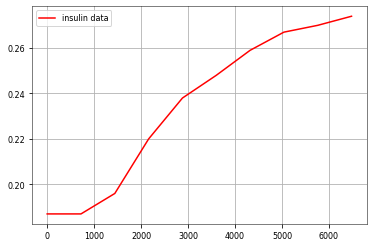

In [36]:
plot(time,datai,labely='insulin data')

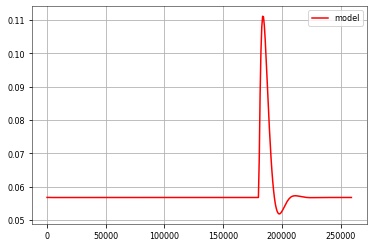

In [37]:
# zobrazime hladinu insulinu modelu, v normalnim fyziologickem stavu
plot(result1['time'],result1['glucoseInsulinRegulation.insulinConc'],labely='model')

In [38]:
result2 = simulatemodelnu(0.12)

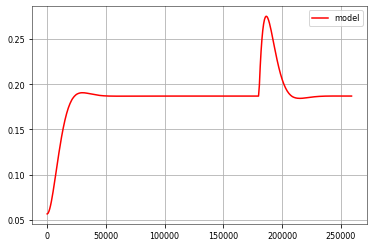

In [39]:
plot(result2['time'],result2['glucoseInsulinRegulation.insulinConc'],labely='model')

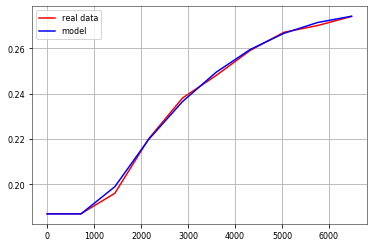

In [40]:
plot(time,datai,result2['glucoseInsulinRegulation.insulinConc'][cindex:cindex+10],labely='real data',labelz='model')

In [34]:
result2['glucoseInsulinRegulation.insulinConc'][cindex:cindex+10]

SimulationResult([0.1869044 , 0.1869044 , 0.19890173, 0.21974466,
                  0.23643512, 0.24942934, 0.25938893, 0.26655931,
                  0.27133707, 0.27408637])

# Další úkoly
Určete parametry beta nebo nu pro pacienty B a C, data v podadresari `data`.

# Jine metody nez hrubá síla

- Monte Carlo - ze souboru (1000x1000) možných hodnot vyberu náhodně podmnožinu hondot, vyberu tu která se nejvíc blíží reálným datům  
- Optimalizační algoritmy `import scipy.optimize as optim`